# 4.3 Bond-slip elasto-plastic model with isotropic and kinematic hardening 
This notebook generalizes the implementation shown in notebook 4.2  time integration algorithm for plasticity modes. Instead of explicitly introducing individual state variables it uses vectors that can represent both different types of state representation and also different dimensions. In this way, a reader is introduced to a more abstract representation of the model components which is the basis for the next step, an introduction of thermodynamically based models. The ingredients of a thermodynamically based material model are

 - Vector of state variables $\boldsymbol{\mathcal{E}}$
 - Vector of streses $\boldsymbol{\mathcal{S}}$
 - Yield condition  $f(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$
 - Flow potential $\varphi(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$

As we consider only associative plasticity in this notebook, $\varphi = f$.

The time-stepping algorithm gets generated automatically within the thermodynamically framework. The derived  evolution equations and return-mapping to the yield surface is performed using Newton scheme.  

In [1]:
%matplotlib notebook
import sympy as sp
sp.init_printing()
import matplotlib.pyplot as plt
import numpy as np

## Model components

### Material parameters

In [32]:
E_b = sp.Symbol('E_b', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True, nonnegative=True)
K = sp.Symbol('K', real=True)
tau_bar = sp.Symbol(r'\tau_{\mathrm{Y}}', real=True, nonnegative=True)

In [34]:
py_vars = ('E_b', 'gamma', 'K', 'tau_bar')
map_py2sp = {py_var : globals()[py_var] for py_var in py_vars}
sp_vars = tuple(map_py2sp[py_var] for py_var in py_vars)

&nbsp;<font color='blue'>
**Names of mathematical symbols in `sympy`:**
    
Mathematical symbols defined as string in `sp.symbols(r'\tau')` use `latex` syntax to introduce greek symbols, super and subindexes. This makes the pretty printing of expression possible. However, leads sometimes to problems when generating executable functions using `sp.lambdify`. Because latex symbols can contain special characters not allowed for latex symbols, this might lead to problems. This issue is fixed here using naming dictionaries `map_py2sp` and two ordered tuples `py_vars` and `sp_vars` containing the `sympy` symbols and string names of the symbols. They are needed to enable the generation of executable `Python` or `C` code. This will be simplified in future releases. 
</font>

### State variables

In [35]:
s = sp.Symbol('s', real=True)
s_pi = sp.Symbol(r's_pi', real=True)
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)

In [36]:
Eps = sp.Matrix([s_pi, z, alpha])
Eps.T

### Conjugate stress variables

In [37]:
tau = sp.Symbol('tau', real=True)
X = sp.Symbol('X', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)

In [38]:
Sig = sp.Matrix([tau, Z, X])
Sig.T

The constitutive laws relating the conjugate forces and kinematic state variables are defined as follows

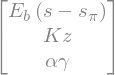

In [39]:
Sig_Eps = sp.Matrix([[E_b * (s - s_pi), K * z, alpha * gamma]]).T
Sig_Eps

**Executable code for** $\boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

In [40]:
get_Sig = sp.lambdify(
    (s, Eps) + sp_vars, Sig_Eps.T, 'numpy'
)

To derive the time stepping procedure we will need also the matrix of derivatives of the generalized stresses $\boldsymbol{\mathcal{S}}$ with respect to the kinematic variables $\boldsymbol{\mathcal{E}}$ 
\begin{align}
\frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}
\end{align}

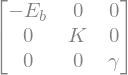

In [41]:
dSig_dEps = sp.Matrix([Sig_Eps.T.diff(eps) for eps in Eps]).T
dSig_dEps

**Executable Python code generation** $\displaystyle{\frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}}(s,\boldsymbol{\mathcal{E}})$

In [42]:
get_dSig_dEps = sp.lambdify(
    (s, Eps) + sp_vars, dSig_dEps, 'numpy'
)

### Threshold function

To keep the framework general for different stress norms and hardening definitions let us first introduce a general function for effective stress. Note that the observable stress $\tau$ is identical with the plastic stress $\tau_\pi$ due to the performed sign switch in the definition of the thermodynamic forces.

In [43]:
f_Sig = sp.sqrt((tau - X)*(tau - X)) - (tau_bar + Z)
f_Sig

**Executable code generation** $f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$

Note that this is a function of both the forces and kinematic state variables

In [44]:
get_f_Sig = sp.lambdify(
    (Eps, Sig) + sp_vars, f_Sig, 'numpy'
)

The derivative of $f$ required for time-stepping $\partial_\boldsymbol{\mathcal{S}} f$ is obtained as

In [45]:
df_dSig = f_Sig.diff(Sig)
sp.simplify(df_dSig).T

**Executable code generation** $\partial_\boldsymbol{\mathcal{S}}f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [46]:
get_df_dSig = sp.lambdify(
    (Eps, Sig) + sp_vars, df_dSig, 'numpy'
)

### Flow direction
Evolution equations have the form
\begin{align}
 \dot{\boldsymbol{\mathcal{E}}} = \lambda \, \boldsymbol{\Phi}
\end{align}
with the vector $\Phi$ representing the flow direction within 
the stress space. Assuming the normality condition, i.e. that 
the flow direction coincides with the vector normal to the 
yield condition we can write
\begin{align}
 \boldsymbol{\Phi} = \boldsymbol{\Upsilon} \frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}
\end{align}
The sign matrix $\boldsymbol{\Upsilon}$ is used to direct all the derivatives in the outward direction from the elastic range.

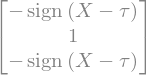

In [47]:
Sig_signs = sp.diag(-1,1,1)
Phi = -Sig_signs * df_dSig
Phi

In [48]:
get_Phi = sp.lambdify(
    (Eps, Sig) + sp_vars, Phi, 'numpy'
)

## Time integration scheme

### Summary of the backward Euler scheme
The derived expressions can be now plugged-in into a generic return mapping algorithm that efficiently identifies a state that satisfies the discrete consistency condition. The general structure of an implicit integration scheme reads
\begin{align}
\boldsymbol{\mathcal{E}}_{n+1} &= \boldsymbol{\mathcal{E}}_{n} +  
\lambda_\Delta \, \boldsymbol{\Phi}_{n+1} \\
f(\boldsymbol{\mathcal{E}}_{n+1};  \lambda_\Delta) &= 0
\end{align}
To reach an admissible state let us linearize the threshold function at an intermediate state $k$ as
\begin{align}
f(\boldsymbol{\mathcal{E}}^{(k)}; \lambda_\Delta^{(k)} )
& \approx
f^{(k)} 
 + 
\left. \frac{\partial f}{\partial \lambda} \right|^{(k)}
\Delta \lambda
\end{align}

Thus, by rewriting the linearized equation as a recurrence formula, the iteration algorithm is obtained
\begin{align}
&\left. \frac{\partial f}{\partial \lambda} \right|^{(k)}
\Delta \lambda =
- f ^{(k)}
\\
&\lambda_{\Delta}^{(k+1)} = \lambda_{\Delta}^{(k)} + \Delta \lambda \\
& \boldsymbol{\mathcal{E}}^{(k+1)}  = 
\boldsymbol{\mathcal{E}}^{(k)} + 
 \lambda_\Delta \, \boldsymbol{\Phi}^{(k)}
 \\
&k = k + 1
\end{align}

To define a generic return mapping we need to construct the  derivatives of the flow rule $f$ with respect to $\lambda$. The dependency of $f$ on $\lambda$ is intermediated via the stresses $\boldsymbol{\mathcal{S}}$ and state variables $\boldsymbol{\mathcal{E}}$
\begin{align}
f(\boldsymbol{\mathcal{S}}(\boldsymbol{\mathcal{E}}(\lambda))).
\end{align}
To correctly resolve the dependencies in the derivative $\frac{\partial f}{\partial_\lambda}$, we need to apply rules for chaining of derivatives. Let us start with the derivative with respect to $\boldsymbol{\mathcal{E}}$ in the form
\begin{align}
\frac{\partial f(\boldsymbol{\mathcal{S}}(\boldsymbol{\mathcal{E}}))}{\partial \boldsymbol{\mathcal{E}}}
 &=
\frac{\partial f(\boldsymbol{\mathcal{S}})}{\partial \boldsymbol{\mathcal{S}}}   \, 
\frac{\partial \boldsymbol{\mathcal{S}}(\boldsymbol{\mathcal{E}})}{\partial \boldsymbol{\mathcal{E}}}.
\end{align}
By expanding the derivatives of $\boldsymbol{\mathcal{E}}$ with respect to $\lambda_\Delta$ that will be abbreviate in index position as $\lambda$ for brevity we obtain
\begin{align}
\frac{\partial f(\boldsymbol{\mathcal{S}}(\boldsymbol{\mathcal{E}}(\lambda)))}{\partial \lambda}
 &=
\frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}   \, 
\frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}
\frac{\partial \boldsymbol{\mathcal{E}}}{\partial \lambda}.
\end{align}

The last term $\frac{\partial \boldsymbol{\mathcal{E}} }{ \partial \lambda}$ can be obtained from the evolution equations
\begin{align}
\boldsymbol{\mathcal{E}} = \lambda \, \boldsymbol{\Phi} \; \implies
\frac{\partial \boldsymbol{\mathcal{E}} }{\partial \lambda} = 
 \boldsymbol{\Phi}
\end{align}

**Summarizing**: the algorithm can be written in a compact way as follows:
\begin{align}
&
\left(
\frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}
^{(k)} \, 
\frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}
^{(k)} \, 
\boldsymbol{\Phi}^{(k)}
\right)
\Delta \lambda = -
f^{(k)}\\
&\lambda_{\Delta}^{(k+1)} = \lambda_{\Delta}^{(k)} + \Delta \lambda \\
& \boldsymbol{\mathcal{E}}^{(k+1)} = \boldsymbol{\mathcal{E}}^{(k)} + 
 \lambda_\Delta \, \boldsymbol{\Phi}^{(k)}
 \\
&k = k + 1
\end{align}

### Implementation concept
The gradient operators needed for the time-stepping scheme have been derived above and are now available for the implementation of the numerical algorithm both in `Python` and `C89` languages

<table style="width:50%">
<tr>
<th>Symbol</th>
<th>Python</th>
<th>C89</th>
</tr>
<tr>
<td>$\mathcal{S}(\boldsymbol{\mathcal{E}}) $  
</td>
<td>get_Sig</td>
<td>get_Sig_C</td>
</tr>
<tr>
<td>$ f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}})$</td>
<td>get_f</td>
<td>get_f_C</td>
</tr>
<tr>
<td>
$\displaystyle{\frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}}(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}})$
    </td>
<td>get_df_dSig</td>
<td>get_df_dSig_C</td>
</tr>
<tr>
<td>
$\displaystyle{\frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}}(\boldsymbol{\mathcal{E}})$</td>
<td>get_dSig_dEps</td>
<td>get_dSig_dEps_C</td>
</tr>
<tr>
<td>$\boldsymbol{\Phi}(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_Phi</td>
<td>get_Phi_C</td>
</tr>
</table>

To avoid repeated calculation of the same expressions, let us put the evaluation of $f$ and $\frac{\partial f}{\partial \lambda}$ into a single procedure. Indeed, the iteration loop can be constructed in such a way that the predictor $\frac{\partial f}{\partial \lambda}$ for the next step is calculated along with the residuum $f$. In case that the residuum is below the required tolerance, the overhead for an extra calculated derivative is negligible or, with some care, it can be even reused in the next time step.  

In [49]:
def get_f_df(s_n1, Eps_k, *margs):
    Sig_k = get_Sig(s_n1, Eps_k, *margs)[0]
    f_k = np.array([get_f_Sig(Eps_k, Sig_k, *margs)])
    df_dSig_k = get_df_dSig(Eps_k, Sig_k, *margs)
    Phi_k = get_Phi(Eps_k, Sig_k, *margs)
    dSig_dEps_k = get_dSig_dEps(s_n1, Eps_k, *margs)
    df_dSigEps_k = np.einsum(
        'ik,ji->jk', df_dSig_k, dSig_dEps_k)
    dEps_dlambda_k = Phi_k
    df_dlambda = np.einsum(
        'ki,kj->ij', df_dSigEps_k, dEps_dlambda_k)
    df_k = df_dlambda
    return f_k, df_k, Sig_k

The update of state variables $\boldsymbol{\mathcal{E}}^{(k+1)}$ for an newly obtained $\lambda_\Delta^{(k+1)}$ is performed using the evolution equations. 

In [50]:
def get_Eps_k1(s_n1, Eps_n, lam_k, Eps_k, *margs):
    Sig_k = get_Sig(s_n1, Eps_k, *margs)[0]
    Phi_k = get_Phi(Eps_k, Sig_k, *margs)
    Eps_k1 = Eps_n + lam_k * Phi_k[:,0]
    return Eps_k1

The double loop over the time increments and over the return mapping iteration. The inner loop represents the material point level in a standard finite element calculation. The input is the maximum slip value, the number of time steps, the maximum number of iterations and a load function which can define cyclic loading as shown below. The procedure returns the record of $\boldsymbol{\mathcal{E}}(t)$ and $\boldsymbol{\mathcal{S}}(t)$

In [51]:
def get_response(margs, s_max=3, n_steps = 10, k_max=20, get_load_fn=lambda t: t):
    Eps_n = np.zeros((len(Eps),), dtype=np.float_)
    Eps_k = np.copy(Eps_n)
    Sig_record, Eps_record, iter_record = [], [], []
    t_arr = np.linspace(0,1,n_steps+1)
    s_t = s_max * get_load_fn(t_arr) + 1e-9
    for s_n1 in s_t:
        lam_k = 0
        f_k, df_k, Sig_k = get_f_df(s_n1, Eps_k, *margs)
        f_k_norm = np.linalg.norm(f_k)
        f_k_trial = f_k[-1]
        k = 0
        while k < k_max:
            if f_k_trial < 0 or f_k_norm < 1e-8:
                Eps_n[...] = Eps_k[...]
                Sig_record.append(Sig_k)
                Eps_record.append(np.copy(Eps_k))
                iter_record.append(k+1)
                break
            dlam = np.linalg.solve(df_k, -f_k)
            lam_k += dlam
            Eps_k = get_Eps_k1(s_n1, Eps_n, lam_k, Eps_k, *margs)
            f_k, df_k, Sig_k = get_f_df(s_n1, Eps_k, *margs)
            f_k_norm = np.linalg.norm(f_k)
            k += 1
        else:
            print('no convergence')
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    return t_arr, s_t, Eps_arr, Sig_arr, iter_arr

## Support functions
To run some examples, let us define some infrastructure including a more complex loading history and postprocessing

### Loading history
This implementation uses the symbolic machinery which is not necessary a simpler data point based implementation with `numpy.interp1d` would be better ... later 

In [52]:
t, theta = sp.symbols(r't, \theta')
n_cycles = 5
A = 2
ups = np.array([((theta-2*cycle)*A+(1-A), theta-2*cycle<=1) 
                for cycle in range(n_cycles)])
downs = np.array([((1-(theta-(2*cycle+1)))*A+(1-A),(theta-(2*cycle+1))<=1) 
                  for cycle in range(n_cycles)])
ups[0,0] = theta
updowns = np.einsum('ijk->jik',np.array([ups, downs])).reshape(-1,2)
load_fn = sp.Piecewise(*updowns).subs(theta,t*n_cycles)
get_load_fn = sp.lambdify(t, load_fn,'numpy')
t_arr = np.linspace(0,1,600)
plt.plot(t_arr, get_load_fn(t_arr));

### Plotting functions
To simplify postprocessing examples, here are two aggregate plotting functions, one for the state and force variables, the other one for the evaluation of energies

In [53]:
def plot_Sig_Eps(t_arr, s_t, Sig_arr, Eps_arr, iter_arr, ax1, ax11, ax2, ax22, ax3, ax33):
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    s_pi_, z_, alpha_ = Eps_arr.T
    sig_pi_, Z_, X_ = Sig_arr.T
    n_step = len(s_pi_)
    ax1.plot(s_t, sig_pi_, color='black', 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    if ax11:
        ax11.plot(s_t, iter_arr, '-.')
    ax2.plot(t_arr, z_, color='green', 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$t$'); ax2.set_ylabel(r'$z$')
    if ax22:
        ax22.plot(t_arr, Z_, '-.', color='green')
        ax22.set_ylabel(r'$Z$')
    ax3.plot(t_arr, alpha_, color='blue', 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$t$'); ax3.set_ylabel(r'$\alpha$')
    if ax33:
        ax33.plot(t_arr, X_, '-.', color='blue')
        ax33.set_ylabel(r'$X$')


In [54]:
from scipy.integrate import cumtrapz
def plot_work(ax, t_arr, s_t, Eps_arr, Sig_arr):
    W_arr = cumtrapz(Sig_arr[:,0], s_t, initial=0)
    U_arr = Sig_arr[:,0] * (s_t-Eps_arr[:,0]) / 2.0
    G_arr = W_arr - U_arr
    ax.plot(t_arr, W_arr, lw=2, color='black', label=r'$W$')
    ax.plot(t_arr, G_arr, color='black', label=r'$G$')
    ax.fill_between(t_arr, W_arr, G_arr, color='green', alpha=0.2)
    ax.set_xlabel('$s$'); ax3.set_ylabel(r'$E$')
    ax.legend()

In [55]:
def plot_dissipation(ax, t_arr, s_t, Eps_arr, Sig_arr):    
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    E_i = cumtrapz(Sig_arr, Eps_arr, initial=0, axis=0)
    c = 'black'
    ax.plot(t_arr, E_i[:,0], '-.', lw=1, color=c)
    ax.fill_between(t_arr, E_i[:,0], 0, color=c, alpha=0.1)
    c = 'black'
    ax.plot(t_arr, E_i[:,0], color=c, lw=1)
    ax.fill_between(t_arr, E_i[:,0], E_i[:,0], 
                    color=c, alpha=0.2);
    c = 'blue'
    ax.plot(t_arr, E_i[:,1], '-.', lw=1, color='black')
    ax.fill_between(t_arr, E_i[:,1], 0, color=c, alpha=0.1)
    c = 'blue'
    ax.plot(t_arr, E_i[:,1] + E_i[:,2], color='black', lw=1)
    ax.fill_between(t_arr, E_i[:,1] + E_i[:,2], E_i[:,1], 
                    color=c, alpha=0.3);

## Examples

In [56]:
material_params = {
    E_b:1, gamma: 0.0, K:0.1, tau_bar:1, 
}
margs = [material_params[map_py2sp[name]] for name in py_vars]

### Monotonic load 
Let's first run the example with different size of the time step to see if there is any difference

<IPython.core.display.Javascript object>


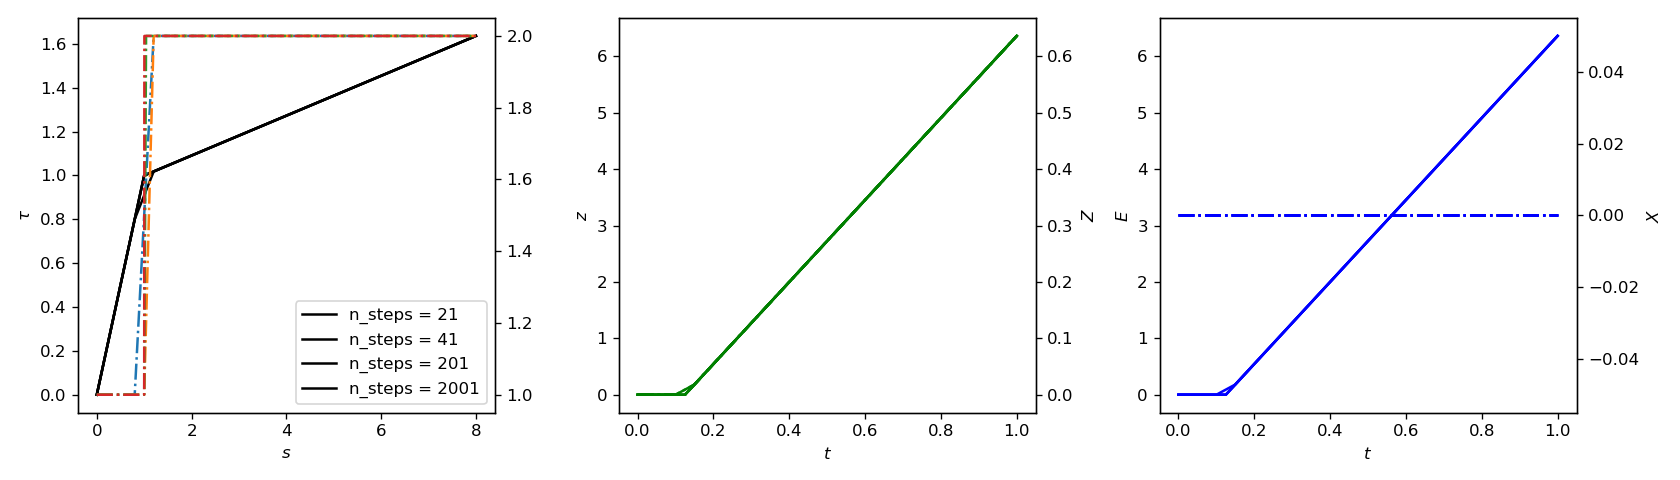

In [57]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(14,4), tight_layout=True)
ax11, ax22, ax33 = ax1.twinx(), ax2.twinx(), ax3.twinx()
for n_steps in [20, 40, 200, 2000]: 
    t_arr, s_t, Eps_arr, Sig_arr, iter_arr = get_response(
        margs=margs, s_max=8, n_steps=n_steps, k_max=10
    )
    plot_Sig_Eps(t_arr, s_t, Sig_arr, Eps_arr, iter_arr, ax1, ax11, ax2, ax22, ax3, ax33)

**Work supply and energy dissipation**

<IPython.core.display.Javascript object>


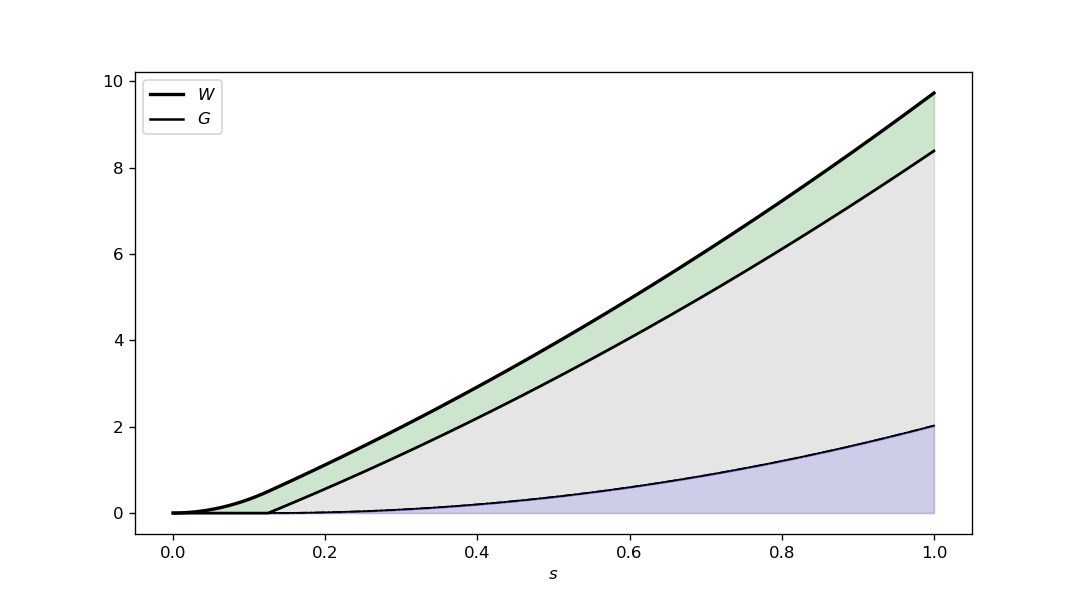

In [58]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, t_arr, s_t, Eps_arr, Sig_arr)
plot_dissipation(ax, t_arr, s_t, Eps_arr, Sig_arr)

### Cyclic loading

<IPython.core.display.Javascript object>


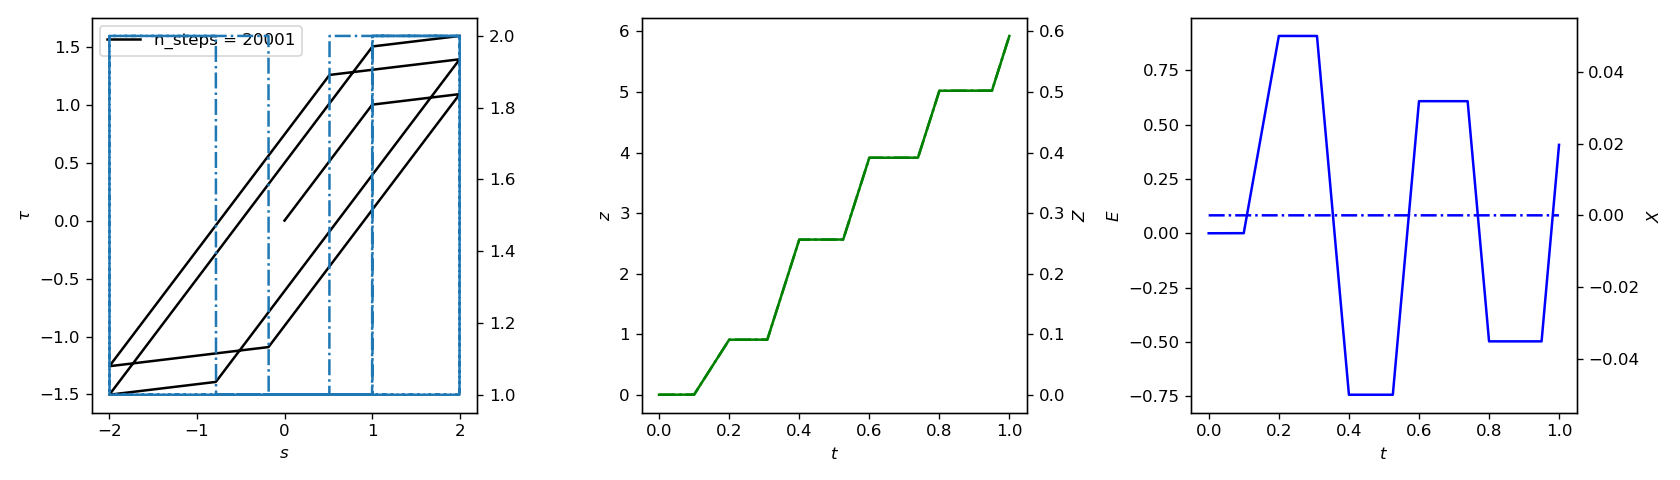

In [59]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(14,4), tight_layout=True)
ax11,ax22,ax33 = ax1.twinx(), ax2.twinx(), ax3.twinx()
t_arr, s_t, Eps_arr, Sig_arr, iter_arr = get_response(
    margs, s_max=2, n_steps=20000, k_max=20, get_load_fn=get_load_fn
)
plot_Sig_Eps(t_arr, s_t, Sig_arr, Eps_arr, iter_arr, ax1, ax11, ax2, ax22, ax3, ax33);

<IPython.core.display.Javascript object>


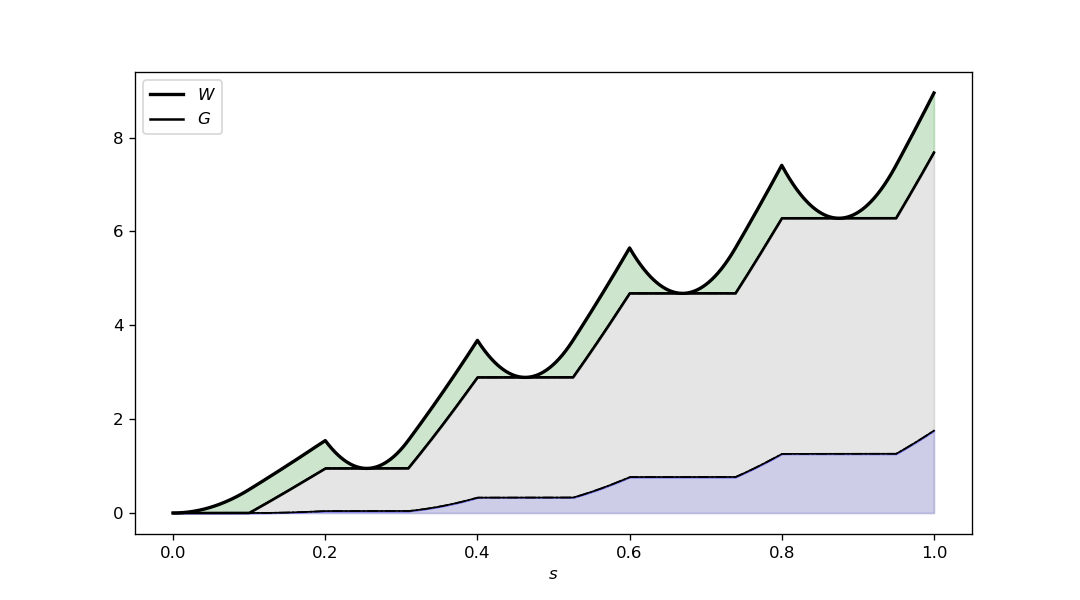

In [61]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, t_arr, s_t, Eps_arr, Sig_arr)
plot_dissipation(ax, t_arr, s_t, Eps_arr, Sig_arr)

## Interactive application

<IPython.core.display.Javascript object>


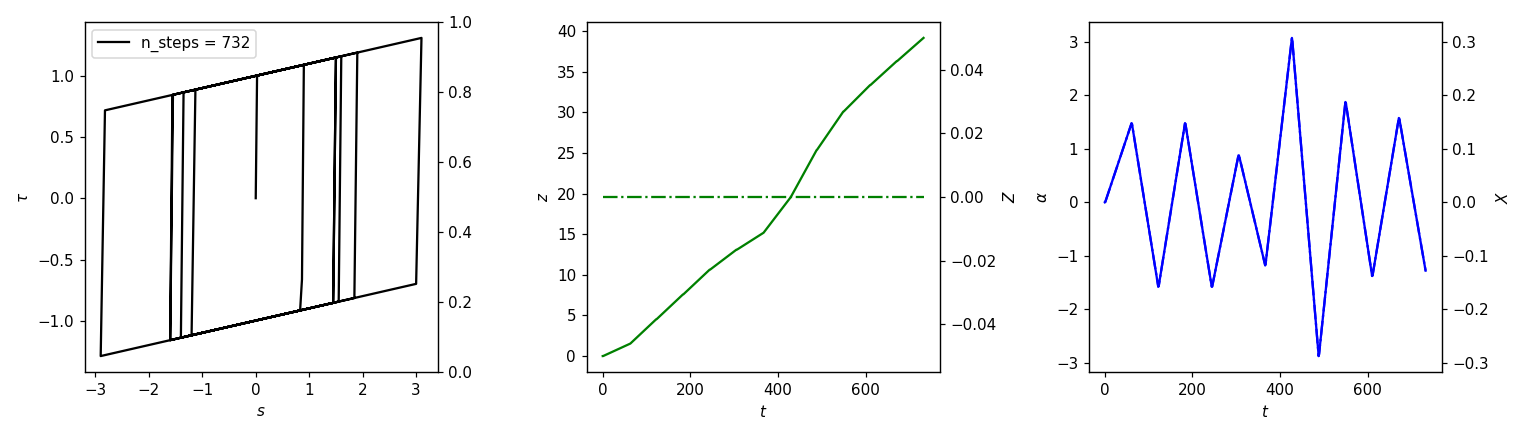

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='s1', max=4.0, min=-4.0), Ou…

interactive(children=(FloatSlider(value=50.0, continuous_update=False, description='E_b', min=0.5, step=4.975)…

In [63]:
def init():
    global Eps_record, Sig_record, iter_record, t_arr, s_t, s0, t0, Eps_n
    s0 = 0
    t0 = 0
    Sig_record = []
    Eps_record = []
    iter_record = []
    t_arr = []
    s_t = []
    Eps_n = np.zeros((len(Eps),), dtype=np.float_)
    
def get_response_i(s1, margs, n_steps = 60, k_max=20):
    global Eps_record, Sig_record, iter_record, t_arr, s_t, s0, t0, Eps_n
    Eps_k = np.copy(Eps_n)
    t1 = t0+n_steps+1
    ti_arr = np.linspace(t0, t1, n_steps+1 )
    si_t = np.linspace(s0,s1,n_steps+1)
    for s_n1 in si_t:
        lam_k = 0
        f_k, df_k, Sig_k = get_f_df(s_n1, Eps_k, *margs)
        f_k_norm = np.linalg.norm(f_k)
        f_k_trial = f_k[-1]
        k = 0
        while k < k_max:
            if f_k_trial < 0 or f_k_norm < 1e-6:
                Eps_n[...] = Eps_k[...]
                Sig_record.append(Sig_k)
                Eps_record.append(np.copy(Eps_k))
                iter_record.append(k+1)
                break
            dlam = np.linalg.solve(df_k, -f_k)
            lam_k += dlam
            Eps_k = get_Eps_k1(s_n1, Eps_n, lam_k, Eps_k, *margs)
            f_k, df_k, Sig_k = get_f_df(s_n1, Eps_k, *margs)
            f_k_norm = np.linalg.norm(f_k)
            k += 1
        else:
            print('no convergence')
    t_arr = np.hstack([t_arr, ti_arr])
    s_t = np.hstack([s_t, si_t])
    t0 = t1
    s0 = s1
    return

import ipywidgets as ipw
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(14,4), tight_layout=True)
ax11 = ax1.twinx()
ax22 = ax2.twinx()
ax33 = ax3.twinx()
axes = ax1, ax11, ax2, ax22, ax3, ax33
axes = ax1, None, ax2, ax22, ax3, ax33
def update(s1):
    global Eps_record, Sig_record, iter_record, t_arr, s_t, s0, t0, Eps_n, axes
    global margs
    get_response_i(s1, margs)
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    for ax in axes:
        if ax:
            ax.clear()
    plot_Sig_Eps(t_arr, s_t, Sig_arr, Eps_arr, iter_arr, *axes)
    
init()

s1_slider = ipw.FloatSlider(value=0,min=-4, max=+4, step=0.1,
                                         continuous_update=False)

ipw.interact(update, s1 = s1_slider);

def reset(**material_params):
    global margs
    init()
    s1_slider.value = 0
    margs = [material_params[name] for name in py_vars]

n_steps = 20
margs_sliders = {
    name : ipw.FloatSlider(description=name, value=val, 
                            min=minval, max=maxval, step=(maxval-minval) / n_steps,
                           continuous_update=False)
    for name, val, minval, maxval in [('E_b', 50, 0.5, 100),
                                     ('gamma', 1, -20, 20),
                                     ('K', 1, -20, 20),
                                     ('tau_bar', 1, 0.5, 20)]
}

ipw.interact(reset, **margs_sliders);